In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam


In [26]:
df = pd.read_csv("weatherHistory.csv")  


In [27]:
df = df[['Formatted Date', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Pressure (millibars)']]

df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])
df.set_index('Formatted Date', inplace=True)

/var/folders/k9/2v1n2cw97z5_1vftpp8ft2br0000gn/T/ipykernel_62008/308759959.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])


In [28]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [29]:
sequence_length = 7  # Weekly data
X = []
y = []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length, 1:])  # Features: Temperature, Apparent Temperature, Humidity, Wind Bearing, Pressure
    y.append(scaled_data[i+sequence_length, 3])    # Target: Wind Speed

X = np.array(X)
y = np.array(y)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [31]:

# Define LSTM + CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [32]:
# Compile the model
model.compile(optimizer=Adam(), loss='mse')

In [33]:

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2)



Epoch 1/10
2412/2412 - 4s - 2ms/step - loss: 0.4203 - val_loss: 0.4071
Epoch 2/10
2412/2412 - 3s - 1ms/step - loss: 0.3960 - val_loss: 0.4073
Epoch 3/10
2412/2412 - 3s - 1ms/step - loss: 0.3928 - val_loss: 0.4101
Epoch 4/10
2412/2412 - 3s - 1ms/step - loss: 0.3911 - val_loss: 0.4016
Epoch 5/10
2412/2412 - 3s - 1ms/step - loss: 0.3889 - val_loss: 0.4034
Epoch 6/10
2412/2412 - 3s - 1ms/step - loss: 0.3873 - val_loss: 0.4020
Epoch 7/10
2412/2412 - 3s - 1ms/step - loss: 0.3839 - val_loss: 0.4071
Epoch 8/10
2412/2412 - 3s - 1ms/step - loss: 0.3818 - val_loss: 0.3968
Epoch 9/10
2412/2412 - 3s - 1ms/step - loss: 0.3806 - val_loss: 0.4015
Epoch 10/10
2412/2412 - 3s - 1ms/step - loss: 0.3783 - val_loss: 0.3938


In [34]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)


603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.3908
Test Loss: 0.3937815725803375


In [35]:
# Make predictions
predictions = model.predict(X_test)


603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step


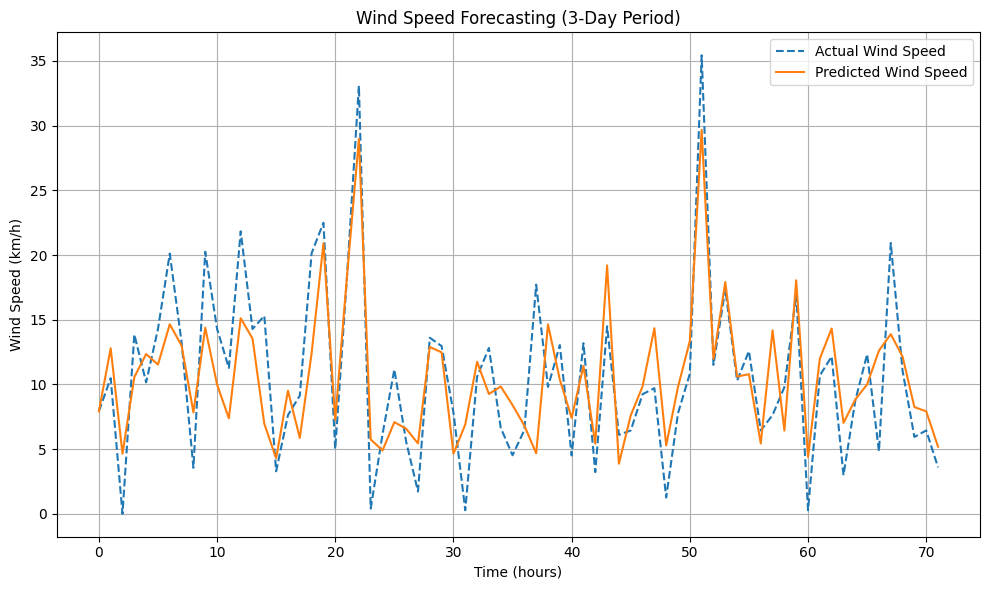

In [36]:
# Calculate mean and standard deviation of wind speed
mean_wind_speed = df['Wind Speed (km/h)'].mean()
std_wind_speed = df['Wind Speed (km/h)'].std()

# Inverse transform the predictions and actual values
predictions_inv = predictions * std_wind_speed + mean_wind_speed
y_test_inv = y_test * std_wind_speed + mean_wind_speed
# Calculate the number of data points for a 3-day period
num_data_points = 3 * 24  # Assuming hourly data, so 3 days * 24 hours/day

# Plot the results for the 3-day period
plt.figure(figsize=(10, 6))

# Plot actual wind speeds with dashed line
plt.plot(y_test_inv[:num_data_points], label='Actual Wind Speed', linestyle='--')

# Plot predicted wind speeds with solid line
plt.plot(predictions_inv[:num_data_points], label='Predicted Wind Speed', linestyle='-')

plt.title('Wind Speed Forecasting (3-Day Period)')
plt.xlabel('Time (hours)')
plt.ylabel('Wind Speed (km/h)')
plt.legend()
plt.grid(True)  # Adding grid for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [37]:
# Evaluate the model on the entire dataset
loss = model.evaluate(X, y, verbose=0)
print("Mean Squared Error (MSE):", loss)

# Calculate RMSE
rmse = np.sqrt(loss)
print("Root Mean Squared Error (RMSE):", rmse)



Mean Squared Error (MSE): 0.3770350515842438
Root Mean Squared Error (RMSE): 0.6140318001408752
